# Linear Regression
Haytham Mohamed

INFS 890 - Spring 2020

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [52]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

data_file = 'order_flow_cleanup_data.csv'
#data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'



test_split = 0.1

In [53]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    

In [54]:
data = read_df(file_dir, data_file, False)
data.head(5)

,date,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,...,orders-db_pods,user_pods,user-db_pods,shipping_pods,payment_pods,carts_pods,carts-db_pods,nodes_cpu_use,orders_req,orders_ltcy
0,2020-03-26 19:46:22,0.030,0.010,0.010,0.010,0.010,0.010,0.010,0.030,0.070,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,2.500,0.150,0.240
1,2020-03-26 19:46:37,0.060,0.020,0.020,0.020,0.020,0.010,0.010,0.180,0.180,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.890,0.150,0.240
2,2020-03-26 19:46:52,0.070,0.030,0.020,0.030,0.020,0.010,0.010,0.440,0.200,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.350,0.150,0.240
3,2020-03-26 19:47:07,0.070,0.030,0.020,0.020,0.020,0.010,0.010,0.230,0.170,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.260,0.130,0.240
4,2020-03-26 19:47:22,0.070,0.020,0.010,0.020,0.020,0.010,0.010,0.240,0.140,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.280,0.360,0.240


In [55]:
data.shape

(6756, 22)

In [56]:
targets = data['orders_ltcy']

inputs = data.drop(['orders_ltcy'], axis=1)
inputs = inputs.drop(['date'], axis=1)

n_features = inputs.values.shape[1]

#inputs_scaled = scaler.fit_transform(inputs)
#x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max

print("there are {} features".format(n_features))

there are 20 features


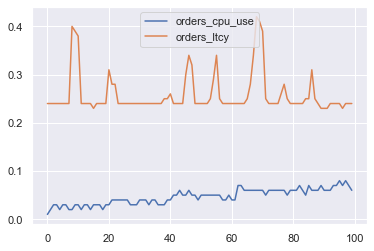

In [57]:
#plt.scatter(data['orders_cpu_use'], data['orders_ltcy'])
#plt.xlabel('orders_cpu_use', size=18)
#plt.ylabel("orders_ltcy", size=18)
#plt.show()

# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][:100], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][:100], label='orders_ltcy')
plt.legend()
plt.show()

#ax = sns.regplot(x=data['orders_cpu_use'], y=data['orders_ltcy'], color='g')


# Regression with Feature Selection

In [58]:
# -- trying features selection 1
#selector = feature_selection.SelectKBest(feature_selection.f_regression).fit(x_train, y_train)
#selectedFeatures = selector.transform(x_train)
#print('{} features selected'.format(selectedFeatures[1].shape[0]))

In [59]:
# -- trying features selection 2
#clf = LassoCV()
#sfm = SelectFromModel(clf) #(clf, threshold=0.01)
#selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
#print('{} features selected'.format(selectedFeatures[1].shape[0]))

In [60]:
# -- trying features selection 3
clf = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15)
sfm = SelectFromModel(clf,threshold='0.8*mean')

In [61]:
# start:  search grid

reg = LinearRegression(normalize=False) # normalize false bacause we are going to use the scaler

# standardize the features
scaler = StandardScaler()
#scaler.fit(x_train.values.reshape(-1,n_features))

pipe = Pipeline(steps=[
    ('scaler', scaler),
    ('selector', sfm), 
    ('clf', reg)
])

kfold = KFold(n_splits=10, shuffle=False)

param_grid = {
    'selector__threshold': ['.1*mean', '.08*mean', '.05*mean', '.02*mean', '.01*mean']
    ,'clf__normalize': [False, True]
}

search = GridSearchCV(pipe, param_grid,scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=0, n_jobs=-1)

search.fit(x_train, y_train)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(bootstrap=True,
                                                                                        ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features='auto',
                     

In [62]:
estimator = search.best_estimator_
params = search.best_params_
score = search.best_score_

print("Best CV score = %0.3f:" % score)
print("Best CV params = {}".format(params))

print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")
print(all_training_scores['mean_train_score'])


Best CV score = -0.100:
Best CV params = {'clf__normalize': False, 'selector__threshold': '.02*mean'}

[-0.07427624 -0.07415584 -0.07341074 -0.06999831 -0.06969429 -0.07423926
 -0.07525386 -0.07320123 -0.06988089 -0.06973983]


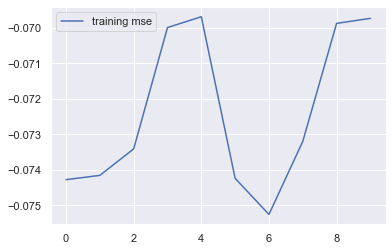

In [63]:
pdf = pd.DataFrame(all_training_scores['mean_train_score'], columns=['training mse'])
pdf.plot()

# Training R2

In [64]:
y_hat = estimator.predict(x_train)

r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))

#print("score ", search.score(x_test, y_test))
# or also R-Squared could be obtain via
#pline.score(x_train, y_train)

R2 (training) = 0.4194460336867962


In [65]:
print('Score (training) = {}'.format(search.score(x_train,y_train)))

Score (training) = -0.07094258121790363


In [66]:
estimator.fit(x_train, y_train)

estimator.named_steps.clf.intercept_

0.2840187815057727

In [67]:
estimator.named_steps.clf.coef_

array([-0.33515835, -0.04486362,  0.02544665, -0.17817871,  0.282895  ,
       -0.05824978,  0.01761037,  0.39758712,  0.14438516,  0.0352829 ,
        0.0352829 ,  0.0352829 ,  0.0352829 , -0.02308289, -0.02981152])

In [68]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.20 (0.18) 0.00 1.10 MSE


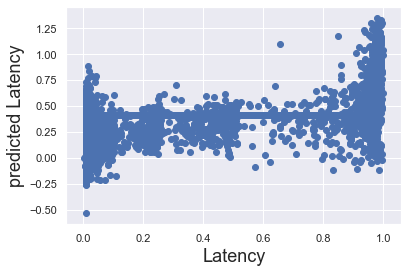

In [69]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

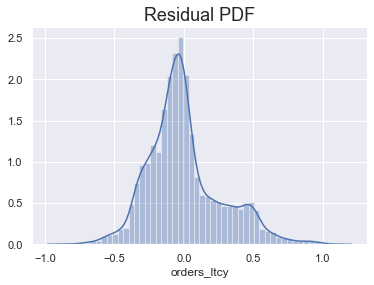

In [70]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

# Testing

In [71]:
y_hat_test = estimator.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

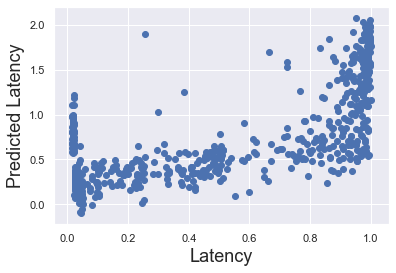

In [72]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

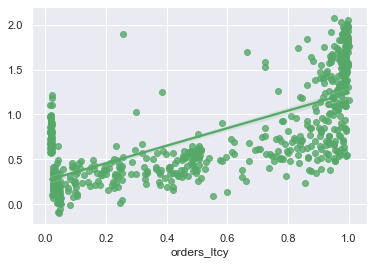

In [73]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [74]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.321,1.026
1,1.227,1.025
2,1.377,1.025
3,1.350,1.025
4,1.318,1.025


In [75]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.321,1.026,0.295,28.775
1,1.227,1.025,0.202,19.677
2,1.377,1.025,0.352,34.366
3,1.350,1.025,0.325,31.753
4,1.318,1.025,0.293,28.571
...,...,...,...,...
671,4.259,2.690,1.569,58.301
672,4.628,2.690,1.938,72.020
673,5.830,2.685,3.145,117.119
674,5.602,2.693,2.909,108.017


In [76]:
perf.describe()

,prediction,target,residual,difference%
count,676.000,676.000,676.000,676.000
mean,2.487,1.784,0.703,45.930
std,1.594,0.696,1.210,48.842
min,0.905,1.016,-1.095,0.057
25%,1.371,1.040,0.008,12.496
50%,1.795,1.616,0.271,26.495
75%,3.073,2.570,1.205,66.402
max,7.970,2.718,5.383,416.348


In [77]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
242,1.51,1.51,0.00,0.06
338,1.66,1.66,-0.00,0.25
76,1.04,1.05,-0.00,0.29
48,1.04,1.05,-0.00,0.34
249,1.51,1.50,0.01,0.36
570,2.52,2.53,-0.01,0.39
193,1.24,1.25,-0.01,0.45
277,1.46,1.47,-0.01,0.62
290,1.97,1.95,0.01,0.66
280,1.27,1.26,0.01,0.69


# Prediction Accuracy

In [78]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = -0.2120148487047926


In [79]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.4456960201538456


# What features selected

In [80]:
x_train.shape

(6080, 20)

In [81]:
#clf = LassoCV()
#sfm = SelectFromModel(clf, threshold=0.001)

threshold_selected = params['selector__threshold']

sfm = SelectFromModel(
                RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15),
                threshold=threshold_selected)

selectedFeatures = sfm.fit(inputs, targets).transform(inputs)
print('{} features selected'.format(selectedFeatures[1].shape[0]))

feature_list = x_train.columns[sfm.get_support()]
features = ''
features = ', '.join(feature_list)
#features

reduced_x_train = x_train[feature_list]
reduced_x_train.head(2)

14 features selected


,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req
0,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.07,1.00,1.00,1.00,2.50,0.15
1,0.06,0.02,0.02,0.02,0.02,0.01,0.01,0.18,0.18,1.00,1.00,1.00,1.89,0.15


# Trying with Polynomial features 

In [82]:
if True:
    from sklearn.preprocessing import PolynomialFeatures

    # covert input data to polynomial form of some degree
    inputs_poly = PolynomialFeatures(degree=2).fit_transform(inputs).astype(float)

    x_train, x_test, y_train, y_test = \
        train_test_split(inputs_poly, targets, test_size=test_split, shuffle=False, random_state=365)

    # for better convergence and result scale target to values between 0 - 1
    y_train_max = y_train.max()
    y_test_max = y_test.max()

    y_train = y_train / y_train_max
    y_test = y_test / y_test_max


    reg = LinearRegression(normalize=False) # normalize false bacause we are going to use the scaler

    scaler = StandardScaler()

    pipe = Pipeline(steps=[
        ('scaler', scaler),
        ('selector', sfm), 
        ('clf', reg)
    ])

    kfold = KFold(n_splits=10, shuffle=False)

    param_grid = {
        'selector__threshold': ['.1*mean', '.08*mean', '.05*mean', '.02*mean', '.001*mean']
    }

    search = GridSearchCV(pipe, param_grid,scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=0, n_jobs=-1)

    search.fit(x_train, y_train)

    y_hat_test = search.predict(x_test)

    r2_test = metrics.r2_score(y_test, y_hat_test)
    print('R2 (testing) = {}'.format(r2_test))


R2 (testing) = 0.30628488585319735


# Robust Linear Model

In [83]:
# RANSAC is an iterative algorithm for the robust estimation of parameters from a subset 
# of inliers from the complete data set.
# you can use this with all dataset including outliers
if False:    
    from sklearn.linear_model import RANSACRegressor

    ransac = RANSACRegressor(estimator)
    ransac.fit(x_train, y_train)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    y_hat_test = ransac.predict(x_test)

    r2_test = metrics.r2_score(y_test, y_hat_test)
    print('R2 (testing) = {}'.format(r2_test))